In [1]:
import numpy as np
import pandas as pd
import os
import csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences 
# from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, f1_score

from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import rdMolDescriptors

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

2023-05-05 15:26:25.356791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## EXTRACT DATA
CSV file to be present in local machine.<br>
FIle name is data.csv

In [2]:
data = []
with open('data.csv', 'r') as csvfile: 
    reader = csv.reader(csvfile, skipinitialspace=True)
    data.append(tuple(next(reader)))
    for ID, SMILE, B, RES, is_active in reader:
        data.append((ID, SMILE, B, RES, is_active))

# remove header
data = data[1:]
maxlen = len(data)
print('Number of entries processed: ', maxlen)

Number of entries processed:  29537


In [3]:
# Get only the SMILES data
SMILES = []
for i in data:
    SMILES.append(i[1])

In [4]:
SMILES[0:2]

['c1(c2c([nH]c1)ccc(c2)OCc1ccccc1)CN(C)C ',
 'c12[nH]c3c(c1CCN=C2C)ccc(c3)O.Cl.O ']

## ONE-HOT ENCODING OF SMILES
This will help in vectrorizing smiles data.<br>
This section will use the tokenizer function that is provided in tensorflow, and we will use keras as the front-end to access the function.<br>
Credit: https://www.kaggle.com/code/art3mis/220221-getting-started-with-smiles <br>
Inspiration: https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76

In [5]:
# Create a tokenizer for vectorization. 
tokenizer = Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts(SMILES)
# Encoding text_to_sequences
sequences = tokenizer.texts_to_sequences(SMILES)
pad_data = pad_sequences(sequences, maxlen=maxlen)
print ('Encoded string:',pad_data[0])

Encoded string: [ 0  0  0 ...  4  2 10]


In [6]:
#sequences_to_text decodes
print ('Decoded string:',tokenizer.sequences_to_texts(pad_data[0:1]))

Decoded string: ['c 1 ( c 2 c ( [ n H ] c 1 ) c c c ( c 2 ) O C c 1 c c c c c 1 ) C N ( C ) C  ']


In [7]:
def decodeOH2SMILES(array, tokenizer):
    # Converts one-hot encoded sequences back to SMILES strings.
    output = tokenizer.sequences_to_texts(array)
    #Modify this if you change the start or end token.
    disallowed_characters = 'E! '
    for character in disallowed_characters:
        output = [i.replace(character,'') for i in output]
    return output

In [8]:
decoded_smiles = decodeOH2SMILES(pad_data[0:2],tokenizer)
print(decoded_smiles)

['c1(c2c([nH]c1)ccc(c2)OCc1ccccc1)CN(C)C', 'c12[nH]c3c(c1CCN=C2C)ccc(c3)O.Cl.O']


## MOLECULAR FINGERPRINT ENCODING OF SMILES
This will help in converting smiles data so that it can be used for applying ML techniques. This is more often used (from surveying)<br>
Credit: https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76

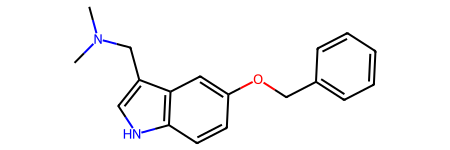

In [9]:
# Drawing molecules
mol = Chem.MolFromSmiles(SMILES[0])
mol

In [10]:
# We will be using RDK fingerprint to vectorize all our SMILES structures
fingerprints = []
for i in range(len(SMILES)):
    mol = Chem.MolFromSmiles(SMILES[i])
    fingerprint_rdk = np.array(RDKFingerprint(mol))
    fingerprints.append(fingerprint_rdk)
fingerprints = np.array(fingerprints)
fingerprints

[15:28:49] WARNING: not removing hydrogen atom without neighbors


array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [11]:
print("Number of features =",fingerprints.shape[1])

Number of features = 2048


## VISUALIZATION OF DATA
Data is obtained from the following paper - https://doi.org/10.1371/journal.pcbi.1010613 <br>
In this paper (and a previous paper of theirs), they conducted a series of HTS to obtain the Average B-score and residual values for a series of small molecules to see their potency against Burkholderia cenocepacia.<br>
Quoting the paper,<br>

"The dataset used in the ML approach consisted of 29,537 compounds with residual growth (RG) values and average B-scores. The RG measures the ratio of bacterial growth in the presence and absence of the compounds. The B-score measures relative potency that adjusts the RG for any screening artifacts resulting from well position (row and column) in the assay plate during the HTS. The B-score is inversely proportional to compound potency, where negative B-scores indicate greater growth inhibitory activity of the compounds. To binarize the compounds, the previously established average B-score threshold of -17.5 was chosen [https://doi.org/10.1371/journal.pone.0128587]. Overall, 256 small molecules were classified as growth inhibitory."

Staying true to the essence of the paper, we will be setting a threshold of -17.5 for B-score in our data as well, i.e. below this threshold, the compound is labeled active, and otherwise inactive.

In [12]:
# Checking data for number of active compounds
# idx - ID, SMILE, B, RES, is_active
count = 0
for i in range(len(data)):
    if float(data[i][2]) <= -17.5:
        if float(data[i][4]) == 1:
            count += 1
print("Number of active compounds =",count)
# This follows what is mentioned in the paper.

Number of active compounds = 256


In [13]:
# Get the B-score values
Bscores = []
active = []
is_active = []
for i in range(len(data)):
    Bscores.append(float(data[i][2]))
    is_active.append(float(data[i][4]))
    if float(data[i][4]) == 0:
        active.append("Inactive")
    else:
         active.append("Active")   
compound_idx = np.arange(len(Bscores))
is_active = np.array(is_active)

[Text(0.5, 0, 'Compound Index'), Text(0, 0.5, 'B-Score')]

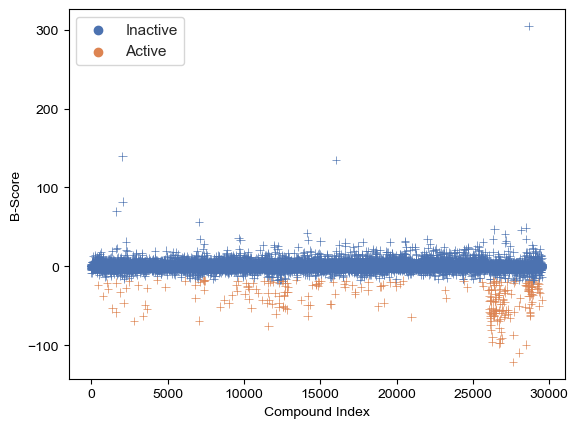

In [14]:
# Visualizing data
# Plot B-scores
fig, ax = plt.subplots()
# plt.scatter(compound_idx[0:100], Bscores[0:100], c ="blue")
sns.set(style='whitegrid')
sns.scatterplot(x=compound_idx,
                    y=Bscores,
                    hue=active, marker='+')
# ax.set_ylim(-500, 100)
ax.set(xlabel='Compound Index', ylabel='B-Score')

## SPLITTING OF DATA
This is an important section because our data is heavily unbalanced. Therefore, we do random undersampling of the major class.


In [24]:
# Includes undersampling of major label to make classes balanced.
def train_test_split(X_resampled, y_resampled, split_ratio=0.8):
#     rus = RandomUnderSampler() # to make it reproducible -- random_state=rng
#     X_resampled, y_resampled = rus.fit_resample(fingerprints, active)
    
    # split data
    # get random permutations
    rand_idx = np.random.permutation(len(X_resampled))
    train_size = round(len(X_resampled)*split_ratio)
    trainX = X_resampled[rand_idx[0:train_size]]
    testX = X_resampled[rand_idx[train_size:len(X_resampled)]]
    trainY = y_resampled[rand_idx[0:train_size]]
    testY = y_resampled[rand_idx[train_size:len(X_resampled)]]
    
    return trainX, trainY, testX, testY

In [32]:
# Includes undersampling of major label to make classes balanced.
def Get_RUS(fingerprints, active, rng=10):
    rus = RandomUnderSampler()#random_state=rng) # to make it reproducible -- random_state=rng
    X_resampled, y_resampled = rus.fit_resample(fingerprints, active)
    return X_resampled, y_resampled


In [26]:
X_resamples, y_resampled = Get_RUS(fingerprints, is_active)
trainX, trainY, testX, testY = train_test_split(X_resamples, y_resampled)

In [27]:
print("Number of active compounds in:")
print("Train Set = ", sum(trainY == 1))
print("Test Set = ", sum(testY == 1))

print("Number of inactive compounds in:")
print("Train Set = ", sum(trainY == 0))
print("Test Set = ", sum(testY == 0))

Number of active compounds in:
Train Set =  207
Test Set =  49
Number of inactive compounds in:
Train Set =  203
Test Set =  53


## IMPLEMENTING LOGISTIC REGRESSION ON MOLECULAR FINGERPRINTS
Logistic regression will be our base learner for this project. Below is the passive learning implementation for the same.

In [28]:
class LogR():
    def __init__(self, x, y):
        self.trainX = x
        self.trainY = y.reshape(len(y),)
        self.model = LogisticRegression(random_state=0, max_iter=500)
    def fit(self):
        self.model.fit(self.trainX, self.trainY)
    def predict(self, x):
        return self.model.predict(x)
#     def predict_prob(self, x):
#         return self.model.predict_proba(x)
#     def predict_logprob(self, x):
#         return self.model.predict_log_proba(x)
    def generate_acc(self, pred, true):
        return accuracy_score(true, pred)

In [29]:
model = LogR(trainX, trainY)
model.fit()
y_pred = model.predict(testX)

In [30]:
model.generate_acc(y_pred, testY)

0.7450980392156863

In [40]:
N_simulations = 100
batch_size = 1
X_resampled, y_resampled = Get_RUS(fingerprints, is_active, rng=10)
trainX, trainY, testX, testY = train_test_split(X_resampled, y_resampled, split_ratio=0.05)
print(len(testX))
N_rounds = len(testX) - 10
performance_mat = np.zeros((N_simulations, N_rounds))
prec_mat = np.zeros((N_simulations, N_rounds))
recall_mat = np.zeros((N_simulations, N_rounds))
f1_mat = np.zeros((N_simulations, N_rounds))

486


In [41]:
X_resampled, y_resampled = Get_RUS(fingerprints, is_active, rng=10)
X_resampled.shape

(512, 2048)

In [42]:
# Run multiple simulations since we are sampling the dataset for train-test-split
for simulations in range(N_simulations):
    np.random.seed(simulations+10)
    X_resampled, y_resampled = Get_RUS(fingerprints, is_active)
    trainX, trainY, testX, testY = train_test_split(X_resampled, y_resampled, split_ratio=0.05)
    print(simulations)
    for r in range(N_rounds):
        model = LogR(trainX, trainY)
        model.fit()
        y_pred = model.predict(testX)
        performance_mat[simulations, r] = model.generate_acc(y_pred, testY)
        # calculate precision, recall, and F1 score
        precision = precision_score(testY, y_pred)
        prec_mat[simulations, r] = precision
        recall = recall_score(testY, y_pred)
        recall_mat[simulations, r] = recall
        f1 = f1_score(testY, y_pred)
        f1_mat[simulations, r] = f1

        selected_samples = np.random.choice(np.arange(testX.shape[0]), size=batch_size)

        trainX = np.concatenate((trainX, testX[selected_samples]), axis=0)
        trainY = np.concatenate((trainY, testY[selected_samples]), axis=0)

        # Delete row from testX
        testX = np.delete(testX, selected_samples, axis=0)
        testY = np.delete(testY, selected_samples, axis=0)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [43]:
avg_acc = np.mean(performance_mat,axis=0)
avg_std = np.std(performance_mat, axis=0)

avg_prec = np.mean(prec_mat, axis=0)
std_prec = np.std(prec_mat, axis=0)
avg_recall = np.mean(recall_mat, axis=0)
std_recall = np.std(recall_mat, axis=0)
avg_f1 = np.mean(f1_mat, axis=0)
std_f1 = np.std(f1_mat, axis=0)

In [44]:
# Save the array to a file
np.save('random_performance'+str(N_simulations)+'.npy', avg_acc)
np.save('random_std'+str(N_simulations)+'.npy', avg_std)

np.save('random_prec'+str(N_simulations)+'.npy', avg_prec)
np.save('random_recall'+str(N_simulations)+'.npy', avg_recall)
np.save('random_f1'+str(N_simulations)+'.npy', avg_f1)

np.save('random_prec_std'+str(N_simulations)+'.npy', std_prec)
np.save('random_recall_std'+str(N_simulations)+'.npy', std_recall)
np.save('random_f1_std'+str(N_simulations)+'.npy', std_f1)

(476,) (476,)


/Users/Mirudhula/opt/anaconda3/envs/IDL2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/Mirudhula/opt/anaconda3/envs/IDL2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


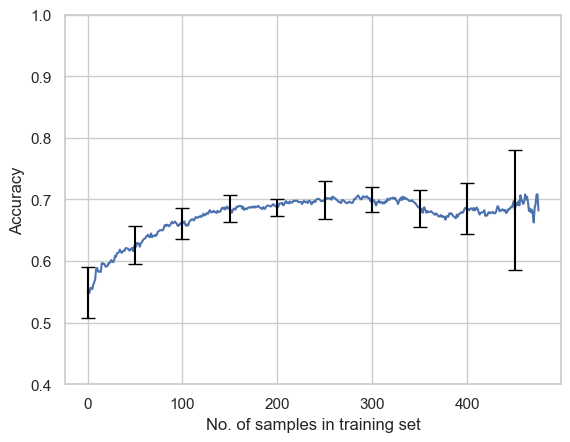

In [40]:
# Create x axis values
xaxis = np.arange(N_rounds)
print(avg_acc.shape, xaxis.shape)
# Create plot
sns.set_style("whitegrid")
# Plot the data with shaded error bars
# Plot the data with error bars
# Create a mask to show error bars only every 50 data points
# Subset arrays to show error bars every 50 on the x-axis
step_size = 50
x_subset = xaxis[::step_size]
y_subset = avg_acc[::step_size]
std_subset = avg_std[::step_size]

# Create line plot with error bars
sns.lineplot(x=xaxis, y=avg_acc, errorbar='ci', err_style='bars')

# Overlay error bars for the subset of data
plt.errorbar(x=x_subset, y=y_subset, yerr=std_subset, fmt='none', color='black', capsize=5, label='Random Learning')# plt.plot(xaxis, avg_acc)
# plt.errorbar(xaxis, avg_acc, yerr = avg_std, color='c', label='Random Learning')
plt.ylim([0.4, 1])
plt.ylabel("Accuracy")
plt.xlabel("No. of samples in training set")
plt.savefig("random_performance_plot.png")
